In [26]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
REGRESSION_DSETS_LARGE_NAMES = data.REGRESSION_DSETS_LARGE_NAMES
import numpy.linalg as npl
from scipy.optimize import minimize
from process_results import process_results, aggregate_results, best_ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

!ls /scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/may14 # may14, may21
parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/may14/'
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
folders = os.listdir(parent_dir)
print(folders)
# folders = [f for f in folders if 'may11' in f]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
clustered  decay  gaussian_scale_var  iid  t  thresh
['clustered', 'iid', 'thresh', 't', 'gaussian_scale_var', 'decay']


# basic loading

In [ ]:
print(os.listdir(parent_dir))
out_dir = oj(parent_dir, 'may11iid') # basic, pmlb_0, clustered, pmlb_1
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not 'processed' in fname]
results = pd.concat(results_list, axis=1).T.infer_objects()

In [ ]:
r = results
r = r[r.model_type == 'mdl']
rr = results[results.model_type == 'ridge']
R, C = 1, 2
plt.figure(dpi=200)

plt.subplot(R, C, 1)
plt.plot(1/r.n_train_over_num_features, r.test_mse, '.', label='mdl')
plt.plot(1/rr.n_train_over_num_features, rr.test_mse, '.', label='ridge')
plt.xscale('log')
plt.xlabel('p/n')
plt.ylabel('test mse')
plt.yscale('log')

plt.subplot(R, C, 2)
plt.plot(1/r.n_train_over_num_features, r.train_mse, '.', label='mdl')
plt.plot(1/rr.n_train_over_num_features, rr.train_mse, '.', label='ridge')
plt.xscale('log')
plt.xlabel('p/n')
plt.yscale('log')
plt.ylabel('train mse')
plt.legend()
plt.tight_layout()
plt.show()

# load results from a directory
**note - this script aggregates results - needs to be done to average across trials to make double descent curves**

In [ ]:
# !rm /scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/*/*processed*
!python process_results.py

# double-descent plots

In [ ]:
plot_all = False
for folder in folders:
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl'))
        
    if plot_all:
        R, C = 2, 3
    else:
        R, C = 1, 2
    SIZE = 5
    plt.figure(figsize=(C * SIZE, R * SIZE))
    plt.subplot(R, C, 1)
    plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for name, curve in tqdm(df.iterrows()):
    #     print(name, curve)
        model_type = name[3]
        reg_param = name[4]
        l = str(model_type) + ' ' + str(reg_param)
        if model_type == 'ols':
            ls = '--'
        elif model_type == 'ridge':
            ls = ':'
        elif model_type == 'linear_sta':
            ls = '-.'
        elif model_type == 'lasso':
            ls = ':'
        elif 'mdl' in model_type:
            ls = '-'
            
        if not model_type == 'linear_sta':


            kwargs = {'label': l, 'alpha': 0.5, 'lw': 2, 'linestyle': ls}

            plt.subplot(R, C, 1)
        #     plt.plot(curve.ratio, curve.mse_test, 
            plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
            plt.ylabel('test mse')
            plt.xlabel('p / n')

            plt.subplot(R, C, 2)
            plt.plot(curve.ratio, curve.mse_train, **kwargs)
            plt.ylabel('train mse')
            plt.xlabel('p / n')


            if plot_all:
                row_best_ridge = best_ridge(df) # contains df1, df2, df3
                len_ridge = row_best_ridge.df1.size                
                
                plt.subplot(R, C, 4)
                plt.plot(row_best_ridge.df1, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df1: $tr(S S^T)$')

                plt.subplot(R, C, 5)
                plt.plot(row_best_ridge.df2, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df2: $tr(2 * S - S^T S)$')

                plt.subplot(R, C, 6)
                plt.plot(row_best_ridge.df3, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df3: $tr(S)$')


            '''
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, np.square(curve.bias), **kwargs)
            plt.ylabel('bias')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['var'], **kwargs)
            plt.ylabel('var')
            '''

            '''
            # wnorm also recorded
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, curve['wnorm'], **kwargs)
            plt.ylabel('wnorm')
            plt.xlabel('p / n')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['num_nonzero'], **kwargs)
            plt.ylabel('num_nonzero')
            plt.xlabel('p / n')
            '''

    for i in range(1, R * C + 1):
        plt.subplot(R, C, i)
        plt.xscale('log')
        plt.yscale('log')

    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    plt.subplot(R, C, 1)
    plt.legend()
    
    if plot_all:
        plt.subplot(R, C, 3)
        ratios = row_best_ridge.ratio
        n = 500 / ratios
        p = 0 * ratios + 500
        plt.plot(ratios, np.minimum(n, p), label='min(n, p)', alpha=0.5)
        plt.plot(ratios, row_best_ridge.df1, label='df1')
        plt.plot(ratios, row_best_ridge.df2, label='df2')
        plt.plot(ratios, row_best_ridge.df3, label='df3')
        plt.xlabel('p / n')
        plt.legend()
    
    
    s = folder
    plt.suptitle(s)
    plt.tight_layout()
    # plt.show()
    plt.savefig(oj(save_dir, s + '.pdf'))
    plt.show()
    plt.close()

# figures

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

LABS = {
    'mdl_m10.0': 'MDL-COMP',
    'ridge-1.0': 'Ridge-CV',
    'mdl_orig0.0': 'MDL-COMP-ORIG',
    'ols0.0': 'OLS'
}

**fig 2 - iid plot**

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


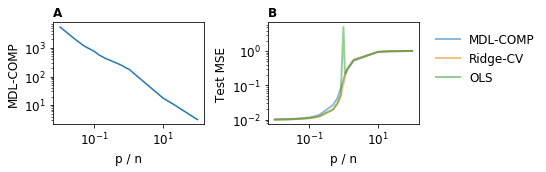

In [43]:
plot_all = False
ls = '-'
folder = 'iid'
out_dir = oj(parent_dir, folder)
df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
df = df[df.model_type != 'mdl_orig'].reset_index()
df = df.iloc[df.model_type.str.slice(1).sort_values().index] # re-order so mdl comes first

R, C = 1, 3
plt.figure(figsize=(9, 2.5))

plt.subplot(R, C, 1)
# plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
plt.title('A', fontweight='bold', loc='left')
#         plt.plot(curve.loss_val, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
plt.ylabel('MDL-COMP')
plt.xlabel('p / n') #\n(Number of features / Number of training points)')
r = pkl.load(open('iid_comp.pkl', 'rb'))
plt.plot(1/r['n_train_over_num_features_list'],
         r['loss_val']) # / r['n_train_over_num_features_list'] / r['num_features'])
'''
def norm(x):
    return x 
plt.plot(1/n_train_over_num_features_list, norm(r['loss_val']), label='loss')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_norm']), label='mse_norm')
plt.plot(1/n_train_over_num_features_list, norm(r['theta_norm']), label='theta_norm')
plt.plot(1/n_train_over_num_features_list, norm(r['eigensum']), label='eigensum')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_test']), label='mse_test')
'''
plt.xscale('log')
plt.yscale('log')




for i in range(df.shape[0]):
    curve = df.iloc[i]
    
    if curve.model_type == 'ridge' and curve.reg_param != -1:
        continue
    kwargs = {'label': LABS[curve.model_type + str(curve.reg_param)],
              'alpha': 0.5, 'lw': 2, 'linestyle': ls}
    
    plt.subplot(R, C, 2)
    plt.title('B', fontweight='bold', loc='left')
    plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
    plt.ylabel('Test MSE')
    plt.xlabel('p / n') #\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')

    '''
    plt.subplot(R, C, 3)
    plt.title('C', fontweight='bold', loc='left')
    plt.plot(curve.ratio, curve.mse_train, **kwargs)
    plt.ylabel('Mean-squared error\n(training)')
    plt.xlabel('p / n')
    plt.xscale('log')
    plt.yscale('log')
    '''
    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.04 ,1), frameon=False)

plt.savefig(oj(save_dir, 'fig_iid.pdf'))
plt.show()

**fig 3 - shifts**

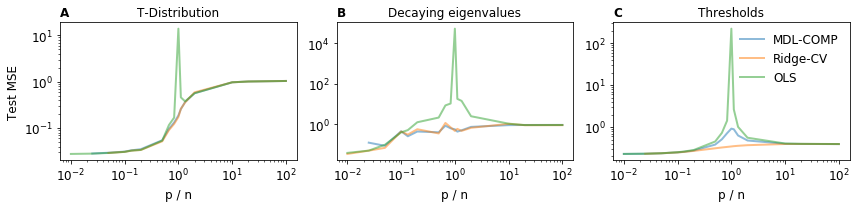

In [44]:
plot_all = False
R, C = 1, 3
lets = ['A', 'B', 'C', 'D', 'E']
titles = {
    't': 'T-Distribution',
    'thresh': 'Thresholds',
    'decay': 'Decaying eigenvalues'
}
plt.figure(figsize=(12, 3))
for j, folder in enumerate(['t', 'decay', 'thresh']): #, 'clustered', 'gaussian_scale_var']):
    plt.subplot(R, C, j + 1)
    plt.title(lets[j], fontweight='bold', loc='left')    
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
    df = df[df.model_type != 'mdl_orig'].reset_index()
    df = df.iloc[df.model_type.str.slice(1).sort_values().index] # re-order so mdl comes first
    
#     plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for i in range(df.shape[0]):
        curve = df.iloc[i]
    
        if curve.model_type == 'ridge' and curve.reg_param != -1:
            continue
        l = LABS[str(curve.model_type) + str(curve.reg_param)]
            

        kwargs = {'label': l, 'alpha': 0.5, 'lw': 2, 'linestyle': ls}

    #     plt.plot(curve.ratio, curve.mse_test, 
        plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
    if j == 0:
        plt.ylabel('Test MSE')
    plt.xlabel('p / n') #\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')

#     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    if j == C - 1:
        plt.legend(frameon=False)
    
    plt.title(titles[folder])
plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_shifts.pdf'))
plt.show()